BUSINESS OBJECTIVE

The objective of this project is to build time series forcasting model to predict the unit sales for thousands of items sold at different Favorita stores.

HYPOTHESIS

Null Hypotesis - onpromotion does not have significant effect on the sales.

Alternate Hypothesis - onpromotion has significant effect on the sales.

ANALYTICAL QUESTIONS

1. Which dates have the lowest and highest sales for each year?
2. Did the earthquake impact sales?
3. Are certain groups of stores selling more products? (Cluster, city, state, type)
4. Are sales affected by promotions, oil prices and holidays?
5. What analysis can we get from the date and its extractable features?
6. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [12]:
import pandas as pd
import numpy as np
import pyodbc
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from xgboost import XGBRegressor
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import warnings


warnings.filterwarnings('ignore')

In [13]:
from dotenv import dotenv_values

# Create a variable to load the files from .env
environment_var = dotenv_values('.env')


# Get the values for the credentials in .env file
server_name = environment_var.get('server_name')
username = environment_var.get('username')
password = environment_var.get('password')
database_name = environment_var.get('database_name')

# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server_name};UID={username};PWD={password};DATABASE={database_name}"


In [14]:
# Use pyodbc for the connection
connection = pyodbc.connect(connection_string)

In [15]:
# Connect with the mysql database to load the dataset
query = "SELECT * FROM dbo.oil;"
oil_data = pd.read_sql(query,connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [16]:
# Convert the oil_data to csv file
oil_data.to_csv("oil.csv",index=False)

In [17]:
# Load the second dataset from the database
query2 = "SELECT * FROM dbo.holidays_events;"
holiday = pd.read_sql(query2,connection)
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [18]:
# Convert the holiday dataframe to csv file
holiday.to_csv("holiday.csv", index=False)

In [19]:
# Load the third dataset from the mysql database
query3 = "SELECT * FROM dbo.stores;"
stores = pd.read_sql(query3,connection)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
# Convert the stores dataframe to csv file
stores.to_csv("store.csv", index=False)

In [21]:
stores.shape

(54, 5)

In [22]:
# Load the fourth dataset from csv file
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.tail()

,id,sales
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0
28511,3029399,0.0


In [23]:
sample_sub.shape

(28512, 2)

In [25]:
# Load the fifth dataset from csv file
test = pd.read_csv("test.csv")
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
# Load the sixth dataset from a csv file
train = pd.read_csv("train.csv", parse_dates=['date'], index_col='date')
train.tail()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148
2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
2017-08-15,3000887,9,SEAFOOD,16.000,0


In [ ]:
# Load the seventh dataset from the csv file
transaction = pd.read_csv("transactions.csv", parse_dates=['date'],index_col='date')
transaction.tail()

,store_nbr,transactions
date,,
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255
2017-08-15,53,932
2017-08-15,54,802


EXPLORATORY DATA ANALYSIS

Exploring the Train dataset

In [ ]:
# Check for the shape of the train dataset
train.shape

(3000888, 5)

In [ ]:
# Check for the info
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
# Check for the null values
train.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
# Check for duplicated rows
train.duplicated().sum()

0

In [ ]:
# Display the summary statistics for the train dataset
train.describe(include='all')

,id,store_nbr,family,sales,onpromotion
count,3.000888e+06,3.000888e+06,3000888,3.000888e+06,3.000888e+06
unique,NaN,NaN,33,NaN,NaN
top,NaN,NaN,AUTOMOTIVE,NaN,NaN
freq,NaN,NaN,90936,NaN,NaN
mean,1.500444e+06,2.750000e+01,NaN,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,NaN,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,NaN,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,NaN,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,NaN,1.958473e+02,0.000000e+00


Check for the inconsistencies in oil dataset

In [ ]:
# Check for the number of rows and columns
oil_data.shape

(1218, 2)

In [ ]:
# Set date as index
oil_data.set_index('date')

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997
...,...
2017-08-25,47.650002
2017-08-28,46.400002
2017-08-29,46.459999


In [ ]:
# Check for the info in oil data
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [ ]:
oil_data['date'] = pd.to_datetime(oil_data['date'] )

In [ ]:
# Check for the null values
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [ ]:
# Fill the null values with backfill methhod since its oil
oil_data['dcoilwtico'].fillna(method='bfill', inplace=True)

In [ ]:
oil_data.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [ ]:
# Check for duplicated rows
oil_data.duplicated().sum()

0

Explore and check for the inconsistencies in holiday datset

In [ ]:
# Check for the number of rows and columns
holiday.shape

(350, 6)

In [ ]:
# Check for the info
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [ ]:
# Convert date data type to datetime
holiday['date'] = pd.to_datetime(holiday['date'])

In [ ]:
# Check for the null values
holiday.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [ ]:
# Check for the duplicated rows
holiday.duplicated().sum()

0

Explore and check for the inconsistencies in the stores dataset

In [ ]:
# Check for the number of rows and columns
stores.shape

(54, 5)

In [ ]:
# Display the store dataset info
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
# Check for the null values
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [ ]:
# Check for duplicated rows and columns
stores.duplicated().sum()

0

Checking for the inconsistencies in transaction dataset

In [ ]:
# Check for the number of rows and columns
transaction.shape

(83488, 2)

In [ ]:
# Check for the columns info
transaction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [ ]:
# Check for the null values
transaction.isnull().sum()

store_nbr       0
transactions    0
dtype: int64

In [ ]:
# Check for the duplicated rows
transaction.duplicated().sum()

45955

In [ ]:
# Display the duplicated rows
duplicated_row = transaction[transaction.duplicated()]
duplicated_row

,store_nbr,transactions
date,,
2013-01-04,26,813
2013-01-04,30,689
2013-01-08,13,879
2013-01-09,51,1786
2013-01-10,19,960
...,...,...
2017-08-15,48,2722
2017-08-15,51,1573
2017-08-15,52,2255


UNIVARIATE ANALYSIS

VISUALIZE THE SALES OVER TIME

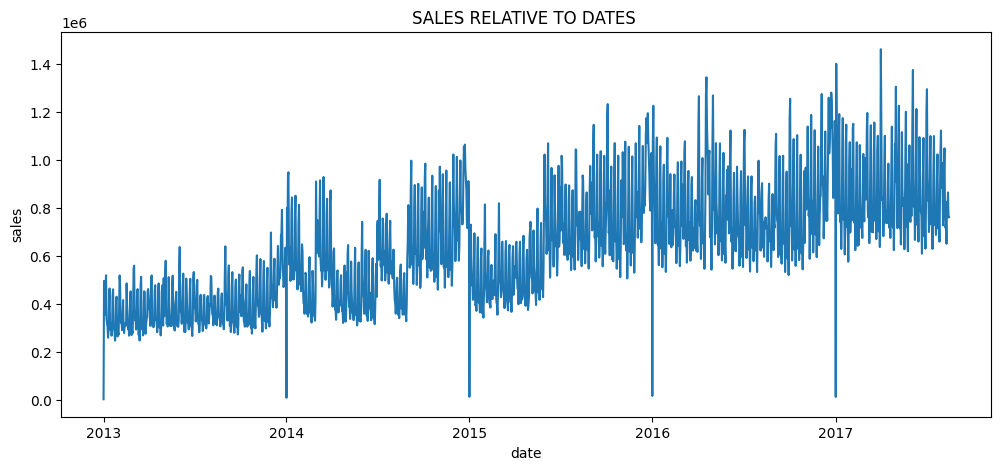

In [ ]:
#Illustrate the change in sales relative to dates
sales_dates =  train.groupby('date')['sales'].sum().reset_index()
 # Visualize the sales_dates relationship using plt
plt.figure(figsize=(12,5))
plt.plot(sales_dates['date'], sales_dates['sales'])
plt.ylabel('sales')
plt.xlabel('date')
plt.title('SALES RELATIVE TO DATES ')
plt.show()


Key Insight:It appears that there is an increasing sales trend in some years.

VISUALIZE THE TRANSACTION OVER TIME

In [ ]:
transaction.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


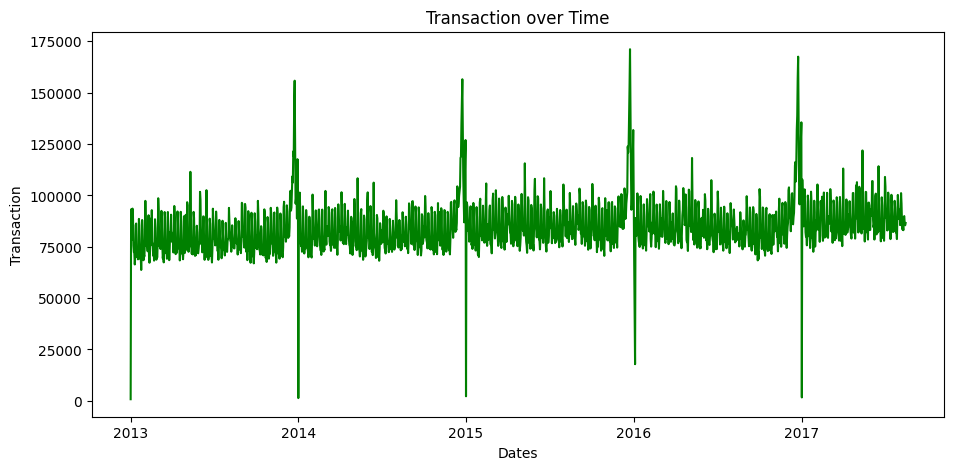

In [ ]:
transaction_dates = transaction.groupby('date').transactions.sum().reset_index()

# Visualize the transaction over time using Seaborn
plt.figure(figsize=(11,5))
sns.lineplot(data=transaction_dates, x='date', y='transactions', color='green')
plt.ylabel('Transaction')
plt.xlabel('Dates')
plt.title('Transaction over Time')
plt.show()



Key Insight: Transactions seem to be stationary in all the years with rise in transaction at the end of every year which signals seasonality.

VISUALIZE THE OIL DATASET

In [ ]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [ ]:
oil_price_dates = oil_data.groupby('date').dcoilwtico.sum().reset_index()

# Visualize using plotly express
fig= px.line(oil_price_dates, x='date', y='dcoilwtico', title='Oil prices over Time')
fig.update_xaxes(title_text='Dates')
fig.update_yaxes(title_text='Oil Prices')
fig.show()


Key Insight: it's observed that there is a decreasing trend in the price of oil at the international market over time.

Visualize oil price distribution using histogram

In [ ]:
fig = px.histogram(oil_data, x='dcoilwtico', nbins=20, title='Oil Price Distribution')
fig.update_xaxes(title_text='Oil Price')
fig.show()

Key Insight: 
It's observed that the oil prices are more frequent between $40 to $60 per barrel at the global market during that period.

Explore the holiday dataset

In [ ]:
holiday.tail(10)

,date,type,locale,locale_name,description,transferred
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False
343,2017-12-21,Additional,National,Ecuador,Navidad-4,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [ ]:
# Display the unique features in type column
holiday.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

Additional days added to calender holidays

In [ ]:
# Display the dataframe that shows the dates where holiday type is additional
holiday[holiday.type == 'Additional']


,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


Days that were added to holidays to extend the break across a long holiday weekend

In [ ]:
# Display dates where the holiday type is BRIDGE
holiday[holiday['type'] == 'Bridge']

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


Days or holidays observed for special events

In [ ]:
# Display the dates observed for Events
holiday[holiday.type == 'Event']

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False


Non-working days that were observed as working days to pay back for the bridge

In [ ]:
holiday[holiday.type == 'Work Day']

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


Holidays that were not transferred but were celebrated on their actual days

In [ ]:
holiday[(holiday['type'] == 'Holiday') & (holiday['transferred'] == False)]

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
337,2017-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False
338,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False


Holidays that were transferred to other dates

In [ ]:
holiday[holiday.transferred == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


Transferred holidays that were observed

In [ ]:
holiday[holiday.type == 'Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


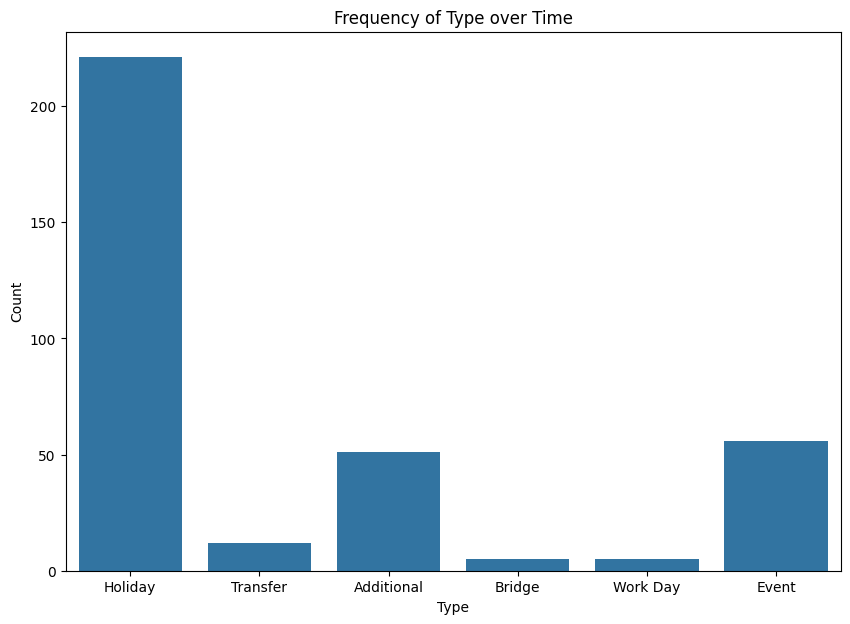

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(data=holiday, x='type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Frequency of Type over Time')
plt.show()

Exploring the stores dataset

In [ ]:
stores.set_index('store_nbr').head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# Use stores variable for type value_counts pandas series
store = stores['type'].value_counts()
store

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [ ]:
store.values

array([18, 15,  9,  8,  4], dtype=int64)

In [ ]:
store.index

Index(['D', 'C', 'A', 'B', 'E'], dtype='object', name='type')

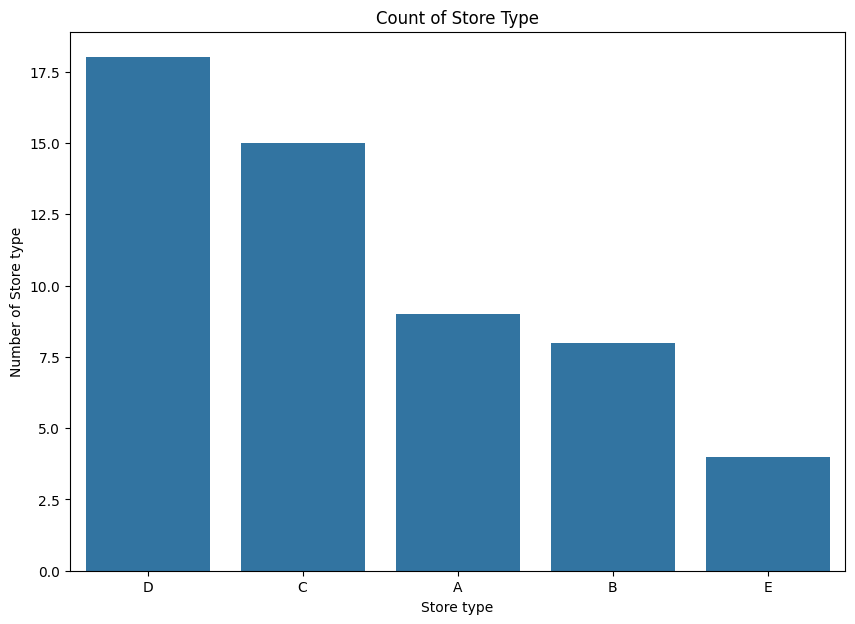

In [ ]:
# Visualize the count of store type
plt.figure(figsize=(10,7))
sns.barplot(y=store.values,x=store.index)
plt.xlabel('Store type')
plt.ylabel('Number of Store type')
plt.title('Count of Store Type')
plt.show()

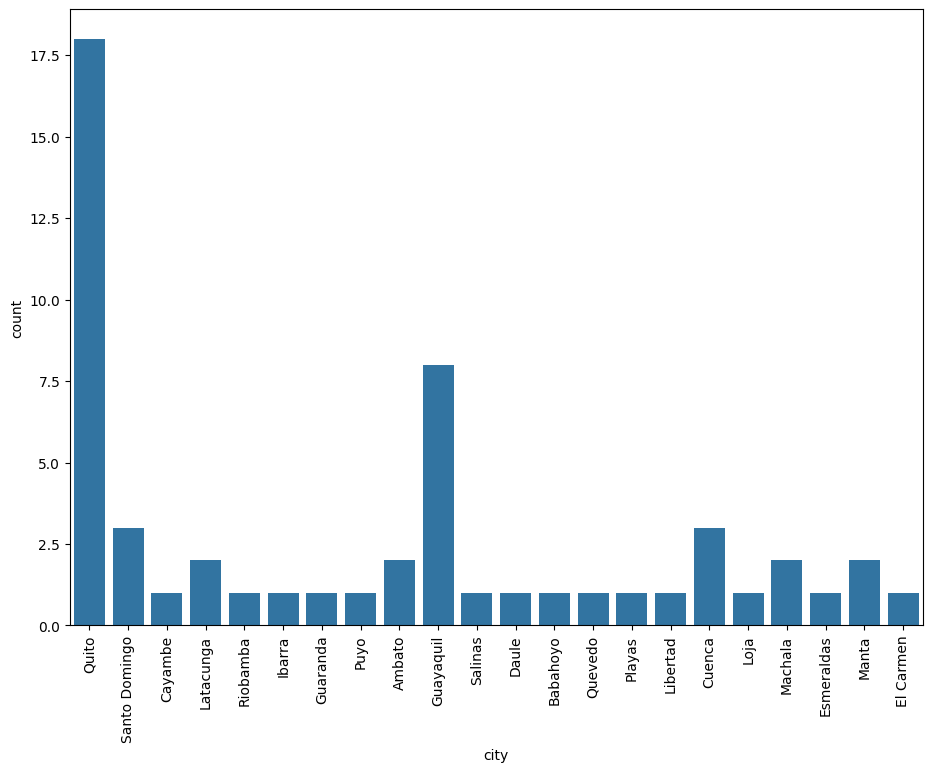

In [ ]:
# Visualize store distribution by city
plt.figure(figsize=(11,8))
sns.countplot(data=stores, x='city')
plt.xticks(rotation=90)
plt.show()

BIVARIATE ANALYSIS

Checking the relationship between oil price and store sales

In [ ]:
# Create a store_sales dataframe from the train dataframe
store_sales = train.groupby('date')['sales'].sum()
store_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [ ]:
# Merge the oil_data with the store_sales on date column
oil_sales = pd.merge(store_sales,oil_data, on='date', how='left')
oil_sales = oil_sales.rename(columns={'dcoilwtico':'Oil Price'})
oil_sales.set_index('date').head().dropna()

,sales,Oil Price
date,,
2013-01-01,2511.618999,93.139999
2013-01-02,496092.417944,93.139999
2013-01-03,361461.231124,92.970001
2013-01-04,354459.677093,93.120003


In [ ]:
# Visualize the relationship using scatterplot
fig = px.scatter(oil_sales, x='Oil Price',y='sales', title='Relationship between Oil Price and Store Sales')
fig.update_xaxes(title_text='Oil Price')
fig.update_yaxes(title_text='Store Sales')
fig.show()

Key Insight:
There is a negative correlation between the Oil price and Store sales.

Checking the relationship between holiday and store sales

In [ ]:
holiday_sales = pd.merge(store_sales,holiday, on='date',how='left')
holiday_sales.set_index('date').dropna().tail()

,sales,type,locale,locale_name,description,transferred
date,,,,,,
2017-07-25,713581.632609,Additional,Local,Guayaquil,Fundacion de Guayaquil,False
2017-08-05,965693.650492,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
2017-08-10,651386.911970,Holiday,National,Ecuador,Primer Grito de Independencia,True
2017-08-11,826373.722022,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
2017-08-15,762661.935939,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
# Visualize the relationship between Store Sales and the holiday types
fig = px.box(holiday_sales, y='sales', x='type', title='Relationship between Store Sales and Holiday Type',height=600)
fig.show()

ANSWERING THE ANALYTICAL QUESTIONS

1. Which dates have the lowest and highest sales for each year?
2. Did the earthquake impact sales?
3. Are certain groups of stores selling more products? (Cluster, city, state, type)
4. Are sales affected by promotions, oil prices and holidays?
5. What analysis can we get from the date and its extractable features?
6. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

1. Which dates have the lowest and highest sales for each year?

In [ ]:
# Create year column in the train dataframe
train['Year'] = train.index.year
train.head()

,id,store_nbr,family,sales,onpromotion,Year
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013
2013-01-01,1,1,BABY CARE,0.0,0,2013
2013-01-01,2,1,BEAUTY,0.0,0,2013
2013-01-01,3,1,BEVERAGES,0.0,0,2013
2013-01-01,4,1,BOOKS,0.0,0,2013


In [ ]:
sales_by_year = train.groupby('Year')['sales'].agg(['min','max'])
sales_by_year

,min,max
Year,,
2013,0.0,46271.000
2014,0.0,45361.000
2015,0.0,40351.460
2016,0.0,124717.000
2017,0.0,38422.625


In [ ]:
# Reset the index to make 'Year' a regular column
sales_by_year_reset = sales_by_year.reset_index()

# Create a line plot using Plotly Express
fig = px.line(sales_by_year_reset, x='Year', y=['min', 'max'],labels={'value': 'Sales', 'Year': 'Year'}, title='Sales Trend by Year')
fig.show()

2. Did the earthquake impact sales?

In [ ]:
# Merge train and transaction dataframe
train_reset = train.reset_index()
transaction_reset = transaction.reset_index()
train_transac = pd.merge(train_reset,transaction_reset, on=['date','store_nbr'], how='left')

In [ ]:
# Reset index to date for train_transac and give it a variable name merged_sales
merged_sales = train_transac.set_index('date')

In [ ]:
# Extract only the April(Earthquake Month) sales from the dataframe and visualize it using plotly
april_sales = merged_sales[(merged_sales.index >= '2016-04-01') & (merged_sales.index <= '2016-04-30')]
daily_sales = april_sales.groupby('date')['sales'].sum()
fig = px.line(x=daily_sales.index,y=daily_sales.values,labels={'x':'date','y':'Sales'},
              title='Daily Sales in April')
fig.update_layout(xaxis=dict(tickangle=45))
fig.show()

3. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
# Merge the train and stores dataset together and group by cluster,city,state and store type
sales_merged = pd.merge(train,stores,on='store_nbr')
grouped_sales =sales_merged.groupby(['cluster','state','city','type']).sales.sum().reset_index()


In [ ]:
# Visualize the grouped_sales using plotly sunburst
fig = px.sunburst(grouped_sales, path=['cluster', 'state', 'city', 'type'], values='sales',
                  title='Grouped Sales by Cluster, State, City, and Store Type')
fig.update_layout(width=1000,height=800)
fig.show()

In [ ]:
fig = px.scatter(grouped_sales, x='state', y='sales',
                 color='cluster', size='sales',
                 title='Scatter Plot of Sales by State and Cluster')
fig.update_layout(width=1000, height=800)
fig.show()

Key Insight:

Type A tends to have the highest sales. Quito City seems to have the hihest Stores sales in Pichincha State with the highest Cluster.

4. Are sales affected by promotions, oil prices and holidays?

In [ ]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [ ]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Drop the year column
train.drop(labels='Year',axis=1,inplace=True)

In [ ]:
promo_sales = train.groupby('onpromotion').sales.sum().reset_index()
fig = px.bar(promo_sales,x='onpromotion',y='sales',color='onpromotion',
              labels={'sales':'Total','onpromotion':'Promotion Status'})
fig.show()

Key Insight:

As indicated above, it appears that the promotion status does not significantly impact total sales, as the highest total sales occur when the promotion status is zero.

CHECK FOR THE MISSING DATES

In [ ]:
dates_range = pd.date_range(start=train.index.min(), end=train.index.max(),freq='D')
missing_dates = dates_range[~dates_range.isin(train.index)]
list(missing_dates)

[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

In [ ]:
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [ ]:
train.tail()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148
2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
2017-08-15,3000887,9,SEAFOOD,16.000,0


In [ ]:
train.reset_index(inplace=True)


In [ ]:
train.head()

,date,id,store_nbr,family,sales,onpromotion
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,1,BABY CARE,0.0,0
2,2013-01-01,2,1,BEAUTY,0.0,0
3,2013-01-01,3,1,BEVERAGES,0.0,0
4,2013-01-01,4,1,BOOKS,0.0,0


In [ ]:
# Make a copy of the original DataFrame before encoding
train_copy = train.copy()

encoder = OneHotEncoder()

# Reshape the 'family' column to a 2D array
family_2d = train_copy['family'].values.reshape(-1, 1)

family_encoded = encoder.fit_transform(family_2d)

# Convert the result to a DataFrame
family_encoded_df = pd.DataFrame(family_encoded.toarray(), columns=encoder.get_feature_names_out(['family']))

# Concatenate the encoded features to the original dataframe
train_encoded = pd.concat([train_copy, family_encoded_df], axis=1)

# Drop the original 'family' column if needed
train_encoded.drop('family', axis=1, inplace=True)


In [ ]:
train_encoded.head()

,date,id,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2013-01-01,0,1,0.0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,1,1,0.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,2,1,0.0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,3,1,0.0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,4,1,0.0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_encoded.set_index('date',inplace=True)

In [ ]:
train_encoded.tail(10)

,id,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-15,3000878,9,11.000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,3000879,9,449.228,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,3000880,9,522.000,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,3000881,9,6.000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,3000882,9,6.000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,3000883,9,438.133,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-08-15,3000884,9,154.553,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3000885,9,2419.729,148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-15,3000886,9,121.000,8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Spliting the dataset into train and test dataset

In [ ]:
cut_off_date = '2016-12-31'
train_encoded.index = pd.to_datetime(train_encoded.index)
train_set = train_encoded[train_encoded.index < cut_off_date]
test_set = train_encoded[train_encoded.index >= cut_off_date]

In [ ]:
train_set.shape, test_set.shape

((2594592, 37), (406296, 37))

Visualize the series

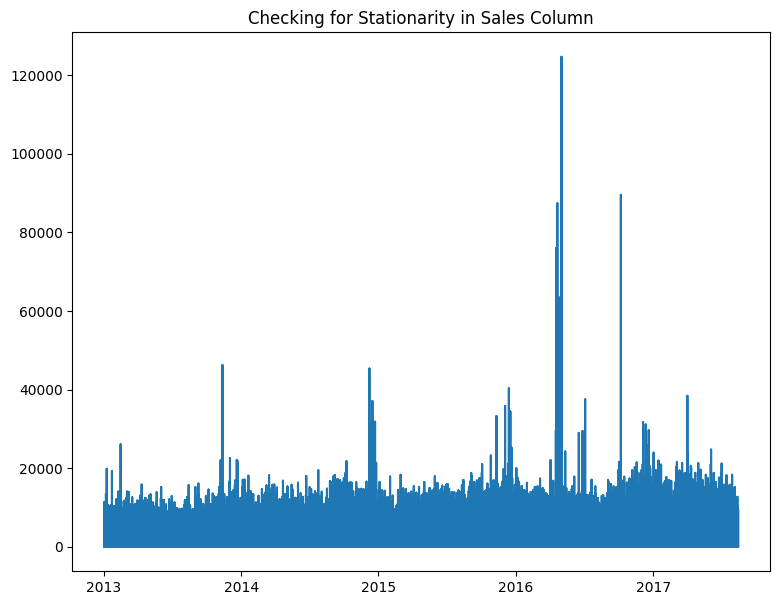

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(train_encoded['sales'])
plt.title('Checking for Stationarity in Sales Column')
plt.show()

DECOMPOSING THE SERIES

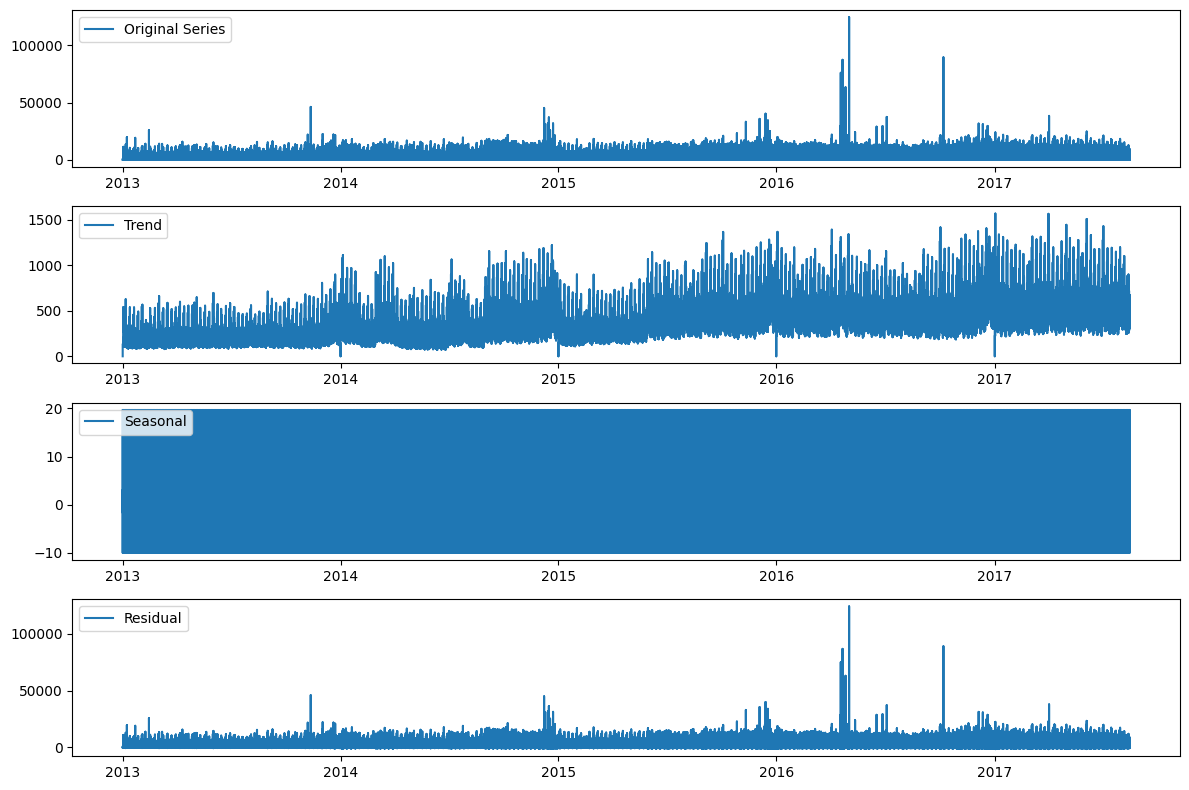

In [ ]:
decom_result  = seasonal_decompose(train_encoded['sales'],model='additive', period=365)

plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(train_encoded['sales'], label='Original Series')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(decom_result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(decom_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(decom_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

STATIONARITY TEST

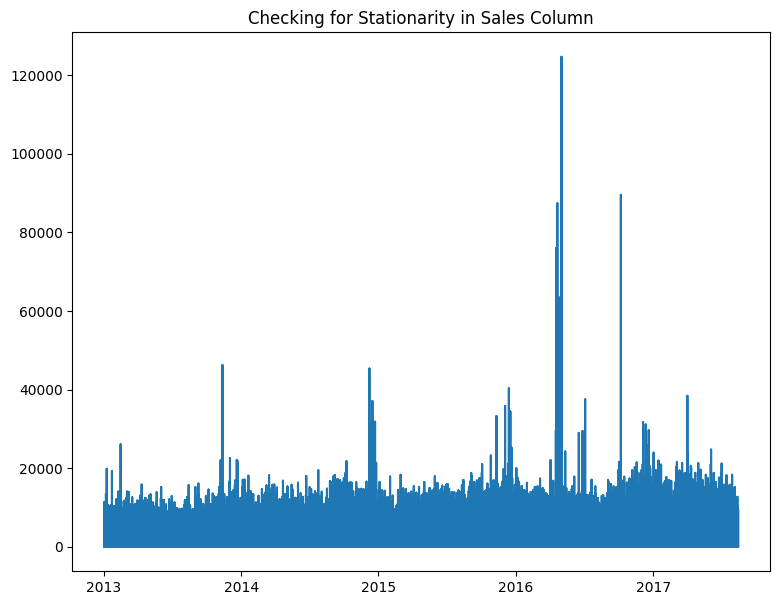

In [ ]:
# test for stationarity using visualization metthod
plt.figure(figsize=(9,7))
plt.plot(train_encoded['sales'])
plt.title('Checking for Stationarity in Sales Column')
plt.show()

USING KPSS TO TEST FOR STATIONARITY

Null hypothesis: series is stationary
Alternate hypothesis: series is not stationary

In [ ]:
kpss_statistic, p_value, critical_values, _ = kpss(train_encoded['sales'],regression='c', nlags='auto')

print('KPSS Statistic:', kpss_statistic)
print('P_VALUE:', p_value)
print('CRITICAL_VALUE:', critical_values)

significance_level = 0.05
if p_value < significance_level:
    print('series is not stationary')
else:
    print('series  is stationary')

KPSS Statistic: 147.40710312148062
P_VALUE: 0.01
CRITICAL_VALUE: 695
series is not stationary


DIFFERENCING

In [ ]:
# Create sales_diff and seasonal_diff variables with 1 lag and 12 month for seasonal
train_encoded['sales_diff'] = train_encoded['sales'] - train_encoded['sales'].shift(1)
train_encoded['seasonal_diff'] = train_encoded['sales'] - train_encoded['sales'].shift(12)

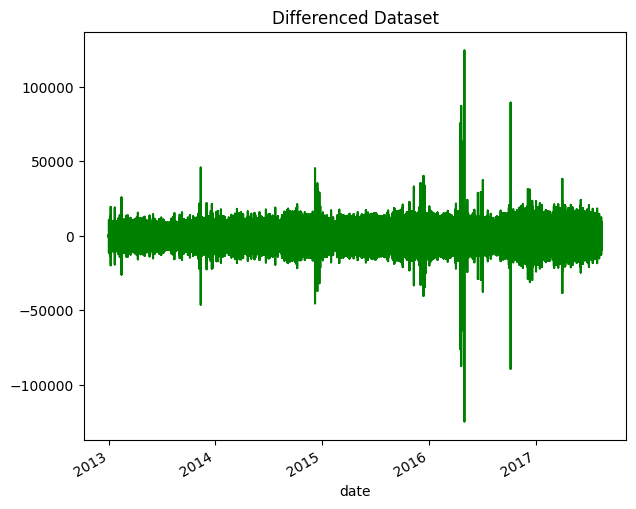

In [ ]:
# Visualize the series after differencing
train_encoded['sales_diff'].plot(figsize=(7,6), color='green')
plt.title('Differenced Dataset')
plt.show()

Key Insight:

The stationarity observed above seems not perfect because the p_value is not set to zero which is 0.05

Check for stationarity after differencing

In [ ]:
train_encoded = train_encoded.dropna()
kpss_statistic, p_value, critical_values, _ = kpss(train_encoded['sales_diff'],regression='c', nlags='auto')

print('KPSS Statistic:', kpss_statistic)
print('P_VALUE:', p_value)
print('CRITICAL_VALUE:', critical_values)

significance_level = 0.05
if p_value < significance_level:
    print('series is not stationary')
else:
    print('series  is stationary')

KPSS Statistic: 0.00012904467342200442
P_VALUE: 0.1
CRITICAL_VALUE: 735
series  is stationary


MODEL

Autocorrelation Function(ACF)  and Partial Autocorrelation Fuction(PACF)

In [ ]:
weekly_resample = train_encoded.resample('W').sum()

In [ ]:
weekly_resample.head()

,id,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,sales_diff,seasonal_diff
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,57154020,294018,2.211570e+06,0,323.0,323.0,323.0,323.0,323.0,323.0,...,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0,36.553,1909.848
2013-01-13,211166109,343035,2.373618e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,-22.034,-497.906
2013-01-20,366766785,343035,2.368007e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,11.667,181.181
2013-01-27,522367461,343035,2.272165e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,2.094,-163.229
2013-02-03,677968137,343035,2.476891e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,8.832,637.505


Key Insight:

The rationale behind the idea of downsampling to weekly above is to minimize the time it takes for the ACF and PACF code to run.


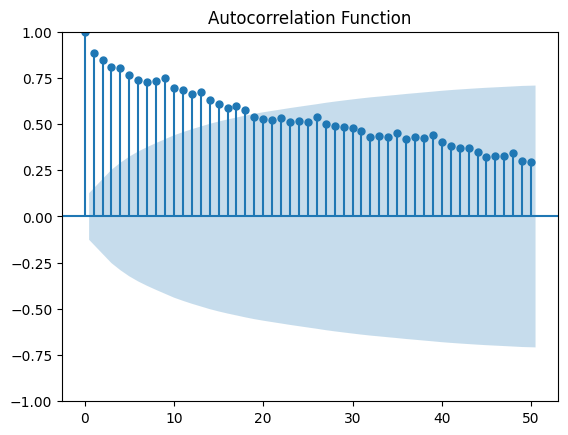

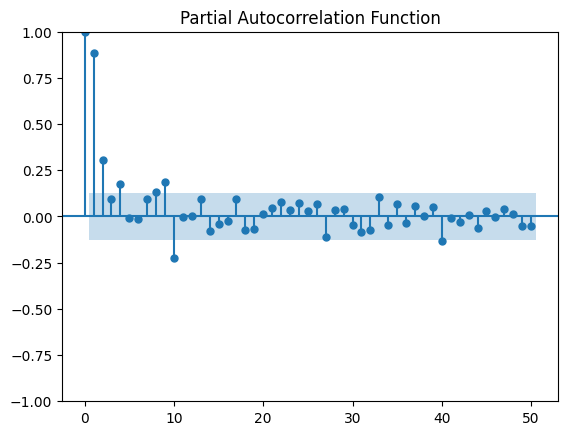

In [ ]:

acf = plot_acf(weekly_resample['sales'],lags=50, title='Autocorrelation Function')
pacf = plot_pacf(weekly_resample['sales'],lags=50, title='Partial Autocorrelation Function')

In [ ]:
# lags = 50
# acf_value = acf(weekly_resample['sales'],nlags=lags)
# pacf_value = pacf(weekly_resample['sales'],nlags=lags)

# #  Identify p and q values based on significant spikes/cuts and add 1 to account for 0 index
# q = np.argmax(acf_value[1:]) + 1
# p = np.argmax(pacf_value[1:]) + 1

# print(f'Estimated q value:{q}')
# print(f'Estimated p value:{p}')



Key Insight:

The values observed for q and p values  from the ACF AND PACF plots above for AR and MA respectively will be used for the classical models.

In [ ]:
# train_encoded_2016 = train_encoded[train_encoded.index.year == 2016]
# train_encoded_2016 = train_encoded_2016.groupby(train_encoded_2016.index).mean()
# train_encoded_2016 = train_encoded_2016.asfreq('D', method='ffill')


Split the weekly_sampled dataset for the models

In [ ]:
cut_off_date = '2016-12-31'
train_encoded.index = pd.to_datetime(train_encoded.index)
train_set = train_encoded[train_encoded.index < cut_off_date]
test_set = train_encoded[train_encoded.index >= cut_off_date]

In [ ]:
cut_off_date = '2016-06-30'
train_data = weekly_resample[weekly_resample.index < cut_off_date]
test_data = weekly_resample[weekly_resample.index > cut_off_date]

In [ ]:
weekly_resample.head()

,id,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,sales_diff,seasonal_diff
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,57154020,294018,2.211570e+06,0,323.0,323.0,323.0,323.0,323.0,323.0,...,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0,36.553,1909.848
2013-01-13,211166109,343035,2.373618e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,-22.034,-497.906
2013-01-20,366766785,343035,2.368007e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,11.667,181.181
2013-01-27,522367461,343035,2.272165e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,2.094,-163.229
2013-02-03,677968137,343035,2.476891e+06,0,378.0,378.0,378.0,378.0,378.0,378.0,...,378.0,378.0,378.0,378.0,378.0,378.0,378.0,378.0,8.832,637.505


In [ ]:
weekly_resample = weekly_resample.drop(labels=['sales_diff','seasonal_diff'], axis=1)

AUTO REGRESSIVE MODEL(AR)

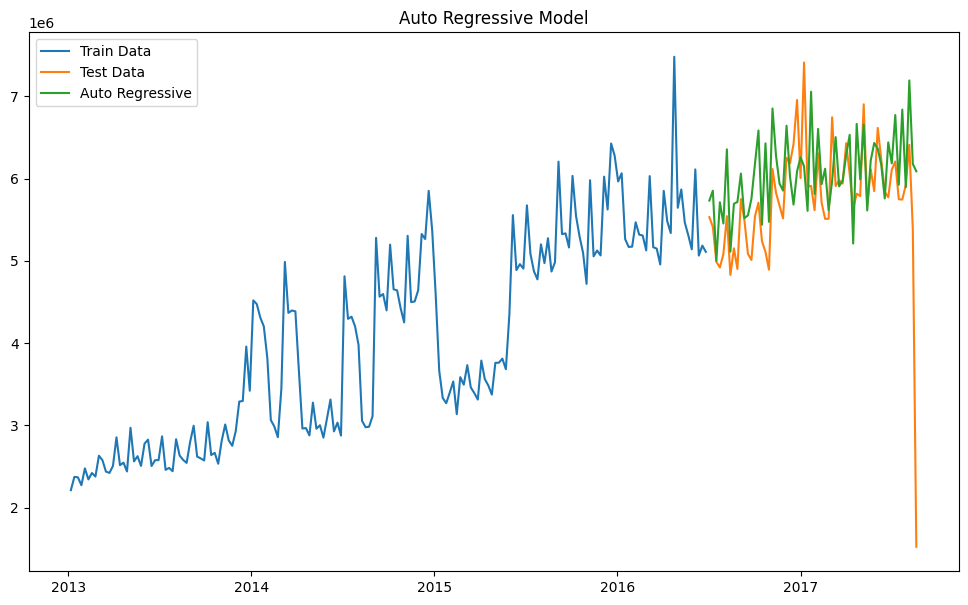

Mean Squared Error (MSE): 659782306059.385
Root Mean Squared Error (RMSE): 812269.8480550568
Mean Squared Logarithmic Error (MSLE): 0.04
Root Mean Squared Logarithmic Error (RMSLE): 0.2


In [ ]:
# Fit the AR model
results = []
lag = 50
model = AutoReg(train_data['sales'],lags=lag)
model_fit = model.fit()

prediction = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Calculate the metrics
true_value = test_data['sales']

mse_ar = mean_squared_error(true_value,prediction)
rmse_ar = np.sqrt(mse_ar)
msle_ar = mean_squared_log_error(true_value, prediction).round(2)
rmsle_ar = np.sqrt(msle_ar).round(2)

# Visualize the AR
plt.figure(figsize=(12,7))
plt.plot(train_data['sales'], label='Train Data')
plt.plot(test_data['sales'], label='Test Data')
plt.plot(prediction,label='Auto Regressive')
plt.legend(loc='best')
plt.title('Auto Regressive Model')
plt.show()

# Print the metric
print(f'Mean Squared Error (MSE): {mse_ar}')
print(f'Root Mean Squared Error (RMSE): {rmse_ar}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_ar}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle_ar}')




MOVING AVERAGE MODEL(MA)

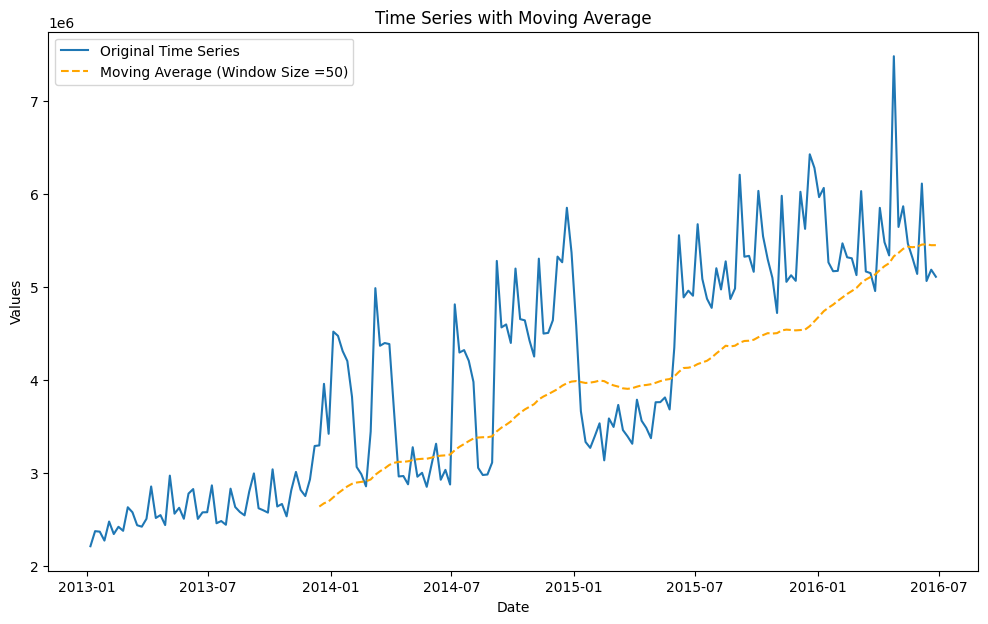

In [ ]:
window_size = 50
train_data['moving_avg'] = train_data['sales'].rolling(window=window_size).mean()

# Visualize the moving average 
plt.figure(figsize=(12,7))
plt.plot(train_data['sales'], label='Original Time Series')
plt.plot(train_data['moving_avg'], label=f'Moving Average (Window Size ={window_size})', linestyle ='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.title('Time Series with Moving Average')
plt.show()


In [ ]:
# Apply MA to the test_data
test_data['moving_avg'] = train_data['sales'].iloc[-window_size:].mean()

# Make prediction
prediction = np.repeat(test_data['moving_avg'].iloc[0],len(test_data))

# Evaluate the  metrics
mse_ma = mean_squared_error(test_data['sales'], prediction)
rmse_ma = np.sqrt(mse_ma)
msle_ma = mean_squared_log_error(test_data['sales'], prediction)
rmsle_ma = np.sqrt(msle_ma)


print(f"Mean Squared Error (MSE): {mse_ma}")
print(f"Root Mean Squared Error (RMSE): {rmse_ma}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle_ma}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_ma}")



Mean Squared Error (MSE): 660110963376.579
Root Mean Squared Error (RMSE): 812472.1308307005
Mean Squared Logarithmic Error (MSLE): 0.03863891006908616
Root Mean Squared Logarithmic Error (RMSLE): 0.19656782562028344


Auto Regressive Integrated Moving Average(ARIMA) Model

In [ ]:
# Use the p and q value from the ACF and PACF plot and shift(1) for the differencing value
p,d,q = 1,1,1

order = (1,1,1)
arima_model = ARIMA(train_data['sales'], order=order)
fit_model = arima_model.fit()

forecast = fit_model.forecast(len(test_data['sales']))

# Evaluate the metrics

# mse_value = mse(test_data['sales_diff'],forecast)
# rmse_value = np.sqrt(mse)
mse_variable = ((test_data['sales'] - forecast) ** 2).mean()
rmse_value = np.sqrt(mse_variable)
msle_variable = mean_squared_log_error(test_data['sales'], forecast)
rmsle_value = np.sqrt(msle_variable)

# print the metrics

print(f"Mean Squared Error (MSE): {mse_variable}")
print(f"Root Mean Squared Error (RMSE): {rmse_value}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle_variable}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_value}")





Mean Squared Error (MSE): 745079952012.4127
Root Mean Squared Error (RMSE): 863180.1387963075
Mean Squared Logarithmic Error (MSLE): 0.04082680899427415
Root Mean Squared Logarithmic Error (RMSLE): 0.20205645001898392


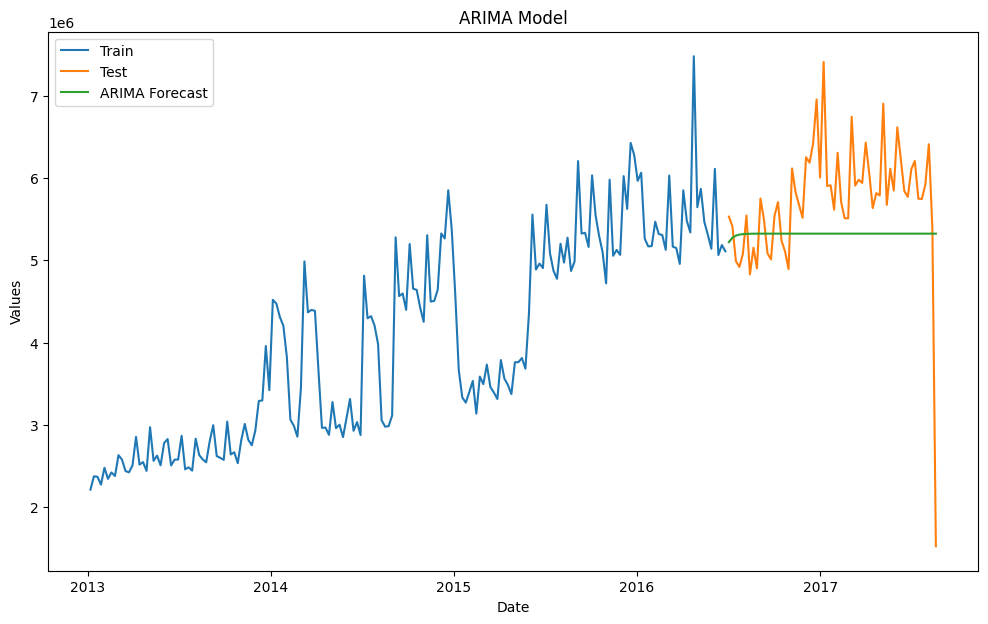

In [ ]:
# Visualize the ARIMA model
plt.figure(figsize=(12,7))
plt.plot(train_data['sales'],label='Train')
plt.plot(test_data['sales'], label='Test')
plt.plot(forecast, label='ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.title('ARIMA Model')
plt.show()

Seasonal Auto Regressive Moving Average(SARIMA) Model

In [ ]:
arima_order = (1,1,1)
seasonal_order = (1,1,1,12) # The seasonality is 12 month

# Fit the SARIMA model
model = SARIMAX(train_data['sales'], order=arima_order, seasonal_order=seasonal_order)
fit_model = model.fit()

# Forecast future values
forecast = fit_model.get_forecast(steps=len(test_data['sales']))
predicted_val = forecast.predicted_mean

# Evaluate the metrics
mse_val = mean_squared_error(test_data['sales'],predicted_val)
rmse_val = np.sqrt(mse_val)
msle_val = mean_squared_log_error(test_data['sales'],predicted_val)
rmsle_val = np.sqrt(msle_val)

# Print the metrics

print(f"Mean Squared Error (MSE): {mse_val}")
print(f"Root Mean Squared Error (RMSE): {rmse_val}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle_val}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_val}")


Mean Squared Error (MSE): 617031455457.4247
Root Mean Squared Error (RMSE): 785513.4979473138
Mean Squared Logarithmic Error (MSLE): 0.039482686202249144
Root Mean Squared Logarithmic Error (RMSLE): 0.198702506784009


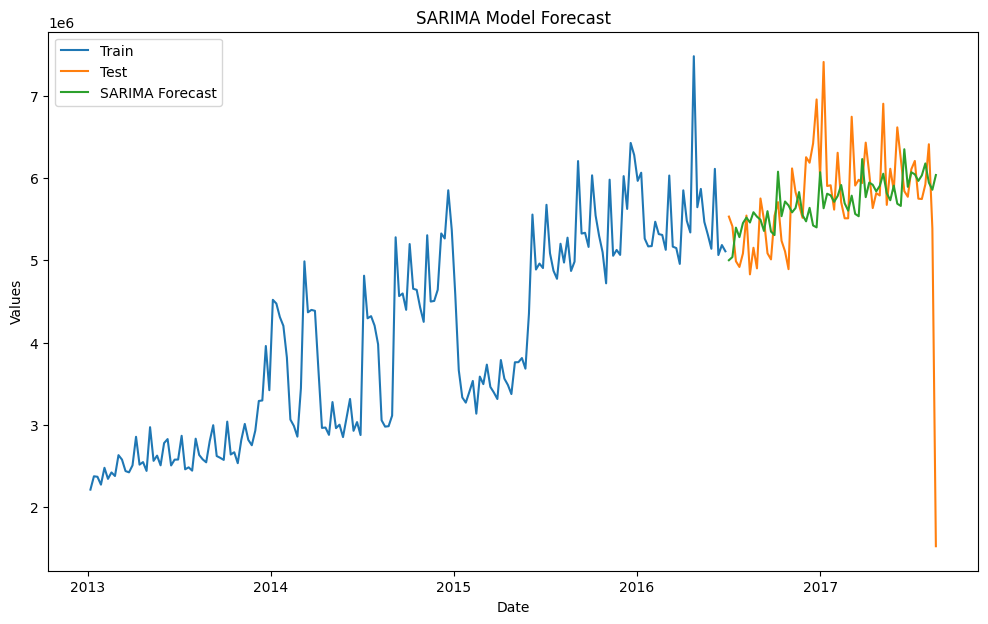

In [ ]:
# Visualize SARIMA model

plt.figure(figsize=(12,7))
plt.plot(train_data['sales'], label='Train')
plt.plot(test_data['sales'], label='Test')
plt.plot(predicted_val, label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

In [ ]:
trace_train = go.Scatter(x=train_data.index, y=train_data['sales'], mode='lines', name='Train')
trace_test = go.Scatter(x=test_data.index, y=test_data['sales'], mode='lines', name='Test')
trace_forecast = go.Scatter(x=test_data.index, y=predicted_val, mode='lines', name='SARIMA Forecast')

# Create layout
layout = go.Layout(title='SARIMA Model Forecast', xaxis=dict(title='Date'), yaxis=dict(title='sales'),height=700)

# Create figure and add traces
fig = go.Figure(data=[trace_train, trace_test, trace_forecast], layout=layout)
fig.show()

SARIMAX Model

In [ ]:
order = (1,1,1)
seasonal_order = (1,1,1,12)
exogenous_variable = train_data['onpromotion'] # Use onpromotion column as the external variable for the SARIMAX model i.e X
model = sm.tsa.SARIMAX(train_data['sales'], exog=exogenous_variable, order=order, seasonal_order=seasonal_order)
sarimax_fit = model.fit()

# forecast with sarima_fit with 'onpromotion' as an external variable
sarimax_forecast = sarimax_fit.get_forecast(steps=len(test_data['sales']),exog=test_data['onpromotion'])
predicted_values = sarimax_forecast.predicted_mean

# Evaluate the metrics
mse_metric = mean_squared_error(test_data['sales'],predicted_values)
rmse_metric = np.sqrt(mse_metric)
msle_metric = mean_squared_log_error(test_data['sales'],predicted_values).round(2)
rmsle_metric = np.sqrt(msle_metric).round(2)

# Print the metrics

print(f"Mean Squared Error (MSE): {mse_metric}")
print(f"Root Mean Squared Error (RMSE): {rmse_metric}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle_metric}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_metric}")

Mean Squared Error (MSE): 640751223650.5687
Root Mean Squared Error (RMSE): 800469.3770848257
Mean Squared Logarithmic Error (MSLE): 0.03
Root Mean Squared Logarithmic Error (RMSLE): 0.17


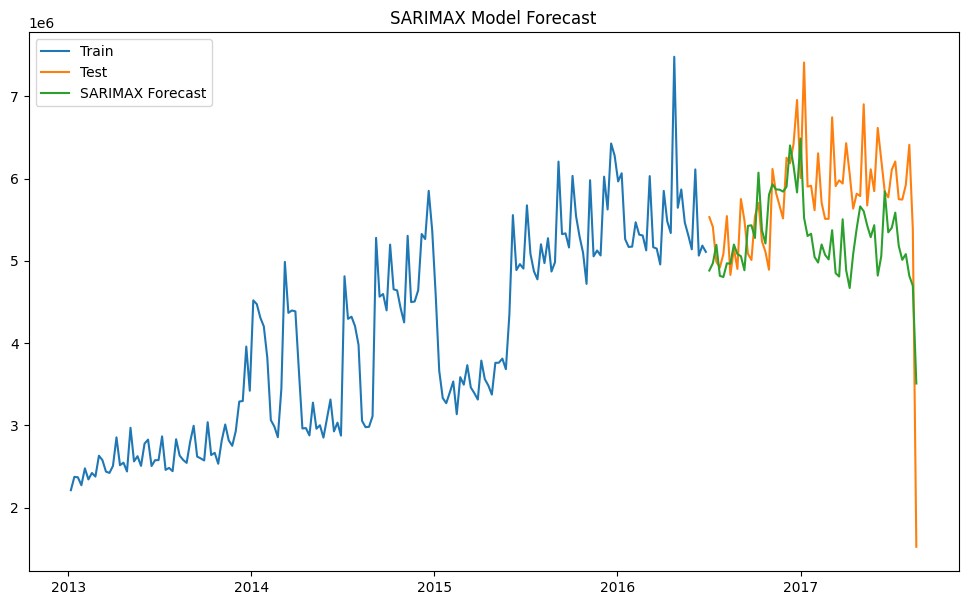

In [ ]:
# Visualize the SARIMAX forecast

plt.figure(figsize=(12,7))
plt.plot(train_data['sales'], label='Train')
plt.plot(test_data['sales'], label='Test')
plt.plot(predicted_values, label='SARIMAX Forecast')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.show()

XGBOOST Model

In [ ]:
#train_encoded.drop(['sales_diff','seasonal_diff'],axis=1,inplace=True)
train_encoded.head()

,id,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,sales_diff,seasonal_diff
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,13,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,14,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,15,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,16,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Split the dataset into training and test set
train_size = int(len(train_encoded)*0.8)
train_set, test_set = train_encoded[:train_size],train_encoded[train_size:]

# Split into feature and target variable
X_train,y_train = train_set.drop(['sales'],axis=1), train_set['sales']
X_test, y_test = test_set.drop(['sales'],axis=1), test_set['sales']


In [ ]:
# Fit the XGBoost model
model = XGBRegressor(n_estimator=200)
fit_model = model.fit(X_train,y_train)

# predict with the test_set
y_pred = fit_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_pred,y_test)
rmse_xgb =np.sqrt(mse_xgb)
# msle_xgb = mean_squared_log_error(y_pred,y_test)
# rmsle_xgb = np.sqrt(msle_xgb)

# Print the metrics

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
# print(f"Mean Squared Logarithmic Error (MSLE): {msle_xgb}")
# print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_xgb}")

Mean Squared Error (MSE): 88982.58874345962
Root Mean Squared Error (RMSE): 298.2994950439233


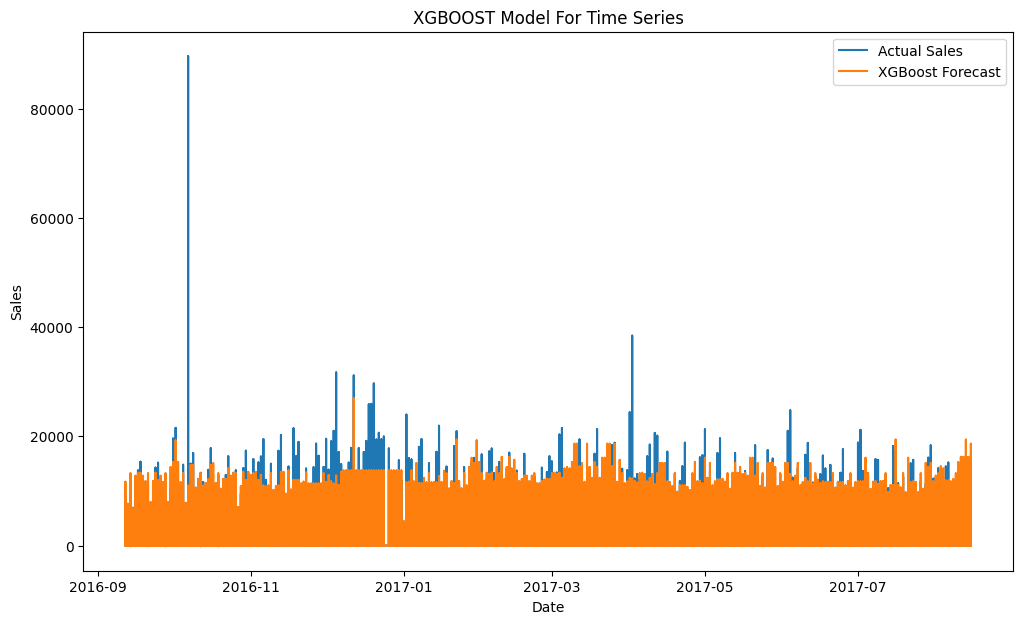

In [ ]:
# Visualize the XGBoost Model
plt.figure(figsize=(12,7))
plt.plot(test_set.index,y_test,label='Actual Sales')
plt.plot(test_set.index,y_pred,label='XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.title('XGBOOST Model For Time Series')
plt.show()

Key Insight:

From the trained models, SARIMAX seems to be the best performing model with MSLE = 0.03 and RMSLE = 0.17.

HYPERPARAMETER TUNING

Tune the best performing model which is SARIMAX

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from itertools import product

tscv = TimeSeriesSplit(n_splits=5)  

# Define the SARIMAX hyperparameters to tune
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # Seasonal frequency 

# Generate all possible combinations of hyperparameters
hyperparameter_grid = list(product(p, d, q, P, D, Q))

best_mse = float('inf')
best_msle = float('inf')
best_params = None

# Split the data and fit the model with different hyperparameter combinations
for param in hyperparameter_grid:
    mse_list = []
    msle_list = []
    for train_index, test_index in tscv.split(weekly_resample):
        train_fold, test_fold = weekly_resample.iloc[train_index], weekly_resample.iloc[test_index]

        order = (param[0], param[1], param[2])
        seasonal_order = (param[3], param[4], param[5], s)

        model = SARIMAX(train_fold['sales'], order=order, seasonal_order=seasonal_order, exog=train_fold['onpromotion'],
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # To Ensure forecast steps do not exceed the length of test data
        forecast_steps = min(len(test_fold), len(results.fittedvalues))
        mse = mean_squared_error(test_fold['sales'][:forecast_steps], results.fittedvalues[:forecast_steps])
        msle = mean_squared_log_error(test_fold['sales'][:forecast_steps], results.fittedvalues[:forecast_steps])

        mse_list.append(mse)
        msle_list.append(msle)

    avg_mse = np.mean(mse_list)
    avg_msle = np.mean(msle_list)

    if avg_mse < best_mse:
        best_mse = avg_mse
        best_msle = avg_msle
        best_params = param

# Print the best hyperparameters and corresponding mean squared error and mean squared logarithmic error
print(f"Best Hyperparameters: {best_params}")
print(f"Best Mean Squared Error: {best_mse}")
print(f"Best Mean Squared Logarithmic Error: {best_msle}")
